In [0]:
#@title Colab Mount
from google.colab import drive
drive.mount('/content/drive')

PROJECT_PATH = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3"
# !git clone "https://85869b109f25ac5241470005fcd8ead1673b1329@github.com/rohanrajpal/dlassignment1.git"
%cd {PROJECT_PATH}

%cd dlassignment1/q3

!git config --global user.email "rohan17089@iiitd.ac.in"
!git config --global user.name "Rohan Rajpal"

# !sudo apt-get install fish -qq > /dev/null
# !sudo apt-get install tmux -qq > /dev/null

%load_ext autoreload
# %cd ..

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3
/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/dlassignment1/q3


In [0]:
#@title Password for SSHD
#1 - setup ssh/user 


#Generate a random root password
import random, string
password = ''.join(random.choice(string.ascii_letters + string.digits) for i in range(30))


#Setup sshd
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null

#Set root password
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config

print("username: root")
print("password: ", password)

#Run sshd
get_ipython().system_raw('/usr/sbin/sshd -D &')


Creating config file /etc/ssh/sshd_config with new version
Creating SSH2 RSA key; this may take some time ...
2048 SHA256:vj9+FuN0nBhkmTM6aK4MKk/Okeyb0z7CyV7y8CFNhzQ root@7d18f00a1e4f (RSA)
Creating SSH2 ECDSA key; this may take some time ...
256 SHA256:lar1pyaEVVAs9o/MnpBXMpQi1ymzHSTtSwQygn4jcKM root@7d18f00a1e4f (ECDSA)
Creating SSH2 ED25519 key; this may take some time ...
256 SHA256:Od8r1j/hTbCqeDEcNHVjBJ8+cKe88OLevMUJ9DKZIP0 root@7d18f00a1e4f (ED25519)
Created symlink /etc/systemd/system/sshd.service → /lib/systemd/system/ssh.service.
Created symlink /etc/systemd/system/multi-user.target.wants/ssh.service → /lib/systemd/system/ssh.service.
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
username: root
password:  NhFTLGDyyX5BgKyiUtQBwCuLTBUNVR


In [0]:
# Collapse
# 2 - Download Ngrok

# ! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# ! unzip -qq -n ngrok-stable-linux-amd64.zip


In [0]:
#@title Setup Ngork

# 3 - setup Ngrok - authtoken

#Ask token
print("Get your authtoken from https://dashboard.ngrok.com/auth")
import getpass
authtoken = getpass.getpass()

#Create tunnel
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')


Get your authtoken from https://dashboard.ngrok.com/auth
··········


In [0]:
#@title Git Stuff
# %cd q3
# !mkdir freeze_model
# !git log --pretty=oneline | head -n 10 
!git pull origin master
# !git commit -m "ok"
# !git diff retinanet/csv_eval.py
# !git status
# !git add Q3.ipynb
# !git add Q3-Rohan.ipynb
# !git commit -m "ok"
# !git add q3/Q3.ipynb
# !git add q3/Old-Q3.ipynb
# !git commit -m "Add notebooks"
# !git push origin master
# !git stash push retinanet/csv_eval.py
# %cd "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/dlassignment1/q3"

In [0]:
#@title Imports
import argparse
import collections

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

from retinanet import model
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer
from torch.utils.data import DataLoader

from retinanet import coco_eval
from retinanet import csv_eval
from matplotlib import pyplot as plt


In [0]:
PATH_TO_DATASET = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data"
PATH_TO_WEIGHTS = PATH_TO_DATASET + "/pretrained_weights_cleaned.pt"
ANNOTATION_CSV ="/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/instances_train_csv.csv"
CLASS_LIST ="/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/class_list.csv"
TRAIN_CSV = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/train.csv"
VAL_CSV = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/val.csv"

# !cat "{ANNOTATION_CSV}"

In [0]:
#@title Clean given weights
pretrained_dict = torch.load(PATH_TO_WEIGHTS)
retina_dict = retinanet.state_dict()

def print_last(comment):
  print(comment,pretrained_dict["classificationModel.output.weight"].size())
  print(comment,pretrained_dict["classificationModel.output.bias"].size())

for k, v in pretrained_dict.items():
  if k in retina_dict:
    if k == "classificationModel.output.weight":
      #do something
      v = v[:72, :, :, :]
    elif k =="classificationModel.output.bias":
      v = v[:72]

    pretrained_dict[k] = v
# 2. overwrite entries in the existing state dict
retina_dict.update(pretrained_dict) 
# 3. load the new state dict
retinanet.load_state_dict(pretrained_dict)


In [0]:
#@title Default title text
%autoreload 2
dataset_train = CSVDataset(train_file = ANNOTATION_CSV, class_list=CLASS_LIST)
retinanet = model.resnet50(num_classes=dataset_train.num_classes(),pretrained=False)

sampler = AspectRatioBasedSampler(dataset_train, batch_size=2, drop_last=False)
dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler)

use_gpu = True

if use_gpu:
    retinanet = retinanet.cuda()

def print_dict(model):
  print("Model's state_dict:")
  for param_tensor in model.state_dict():
      print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# torch.save(retinanet.state_dict(), PATH_TO_DATASET + "/pretrained_weights_cleaned.pt")
# print_dict(retinanet)
# print(givenmodel['classificationModel.output.weight'])

retinanet.load_state_dict(torch.load(PATH_TO_WEIGHTS))

retinanet = torch.nn.DataParallel(retinanet).cuda()

retinanet.training = False
retinanet.eval()
retinanet.module.freeze_bn()
  
coco_eval.evaluate_coco(dataset_train, retinanet)

In [0]:
#@title Make Reduced JSON

# Make Reduced JSON
INSTANCES_TRAIN_PATH = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/instances_train.json"
INSTANCES_TRAIN_ALT_PATH = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/instances_train_alt.json"

IMAGE_PATH = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/images/train/"

with open(INSTANCES_TRAIN_PATH) as f:
  data = json.load(f)

# data_final = {}

# data_final["info"] = data["info"]
# data_final["categories"] = data["categories"]
# data_final["images"] = []
# data_final["annotations"] = []
# import os

# root = IMAGE_PATH
# file_map = {}
# for path, subdirs, files in os.walk(root):
#     if files:
#         print(os.path.join(path, min(files)))
#         for file in files:
#           # print(file)
#           file_map[file] = os.path.join(path, file)

# def inFolder(elem):
#   if elem in file_map:
#     return True
#   # print(elem)
#   return False

# # remove images which arent there
# for elem in data["images"]:
#   if inFolder(elem["file_name"]):
#     data_final["images"].append(elem)

# for elem in data["annotations"]:
#   if inFolder(elem["image_id"]+".jpg"):
#     data_final["annotations"].append(elem)

# print(len(data["images"]),len(data["annotations"]))
# print(len(data_final["images"]),len(data_final["annotations"]))

# f = open(INSTANCES_TRAIN_ALT_PATH,'w')
# json.dump(data_final,f)


In [0]:
#@title Shift all files to train/

# !ls -l "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/"
# with open(INSTANCES_TRAIN_ALT_PATH) as f:
#   data = json.load(f)
# print(len(data["images"]),len(data["annotations"]))
# !mv "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/instances_train.json" "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/temp.json"
# !mv "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/instances_train_alt.json" "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/instances_train.json"

# %cd "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/images"
# !unzip -q train.zip


# import shutil
# IMAGE_PATH = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/images/train"
# for file in file_map.keys():
#   oldpath = file_map[file]
#   newpath = IMAGE_PATH
#   print(oldpath,newpath)
#   # command = "mv " + oldpath+" "+newpath
#   # os.system(command)
#   shutil.move(oldpath,newpath)
  # !mv {oldpath} {newpath}

In [0]:
# !ls -l "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/images/train"
!pwd

In [0]:
#@title Generate annotation CSV
# import csv

# class_map = {
# 11:"bird",
# 6:"bobcat",
# 33:"car",
# 16:"cat",
# 3:"raccoon",
# 10:"rabbit",
# 9:"coyote",
# 5:"squirrel"
# }
# !rm -rf "{ANNOTATION_CSV}"
# with open(INSTANCES_TRAIN_PATH) as f:
#   data = json.load(f)
# f_csv = open(ANNOTATION_CSV, 'w', newline='')
# writer = csv.writer(f_csv)
# for anno in data["annotations"]:
#   img_path = IMAGE_PATH + anno["image_id"] + ".jpg"
#   bbox = [int(x) for x in anno["bbox"]]
#   bbox[2] = bbox[0] + bbox[2]
#   bbox[3] = bbox[1] + bbox[3]
#   if(anno["category_id"] in class_map):
#     class_name = class_map[anno["category_id"]]
#     writer.writerow([img_path,bbox[0],bbox[1],bbox[2],bbox[3],class_name])


In [0]:
!cat "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data/annotations/instances_train_csv.csv"

In [0]:
f_csv = open(CLASS_LIST, 'w', newline='')
writer = csv.writer(f_csv)
lines = [
["bird","0"],
["bobcat","1"],
["car","2"],
["cat","3"],
["raccoon","4"],
["rabbit","5"],
["coyote","6"],
["squirrel","7"]
]
# for line in lines:
#   writer.writerow(line)

In [0]:
# !python visualize.py --dataset csv --csv_classes "{CLASS_LIST}" --csv_val "{ANNOTATION_CSV}" --model "{PATH_TO_WEIGHTS}"
%%time
!python train_freeze.py --dataset csv --csv_train "{TRAIN_CSV}"  --csv_classes "{CLASS_LIST}" --epochs 1 --csv_val "{VAL_CSV}"

Num training images: 1153

Epoch 0
Evaluating dataset

mAP:
bird: 0.08626936957400787
bobcat: 0.44003754465160716
car: 0.9974724264705882
cat: 0.10204147198596142
raccoon: 0.4829078974660162
rabbit: 0.11418080812815078
coyote: 0.000984848484848485
squirrel: 0.09324406853053041
Avg mAP 0.2896423044114638
Best loss: 0.8177677926638097 Best mAP: 0.2896423044114638

Epoch 1
Evaluating dataset

mAP:
bird: 0.1796865668053052
bobcat: 0.49132844764870304
car: 0.9991496598639455
cat: 0.2807920712719537
raccoon: 0.8044566491340999
rabbit: 0.35173673108959
coyote: 0.00908731584620913
squirrel: 0.24309949182427268
Avg mAP 0.4199171166855099
Best loss: 0.5749401108917023 Best mAP: 0.4199171166855099

Epoch 2
Evaluating dataset

mAP:
bird: 0.3202460146402324
bobcat: 0.29501408039551
car: 0.9991666666666666
cat: 0.3612125512901856
raccoon: 0.8415653961300411
rabbit: 0.5807705452961547
coyote: 0.10916017009213325
squirrel: 0.2893325334731463
Avg mAP 0.47455849474800876
Best loss: 0.4663232709777475 Be

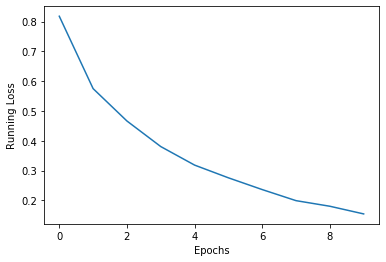

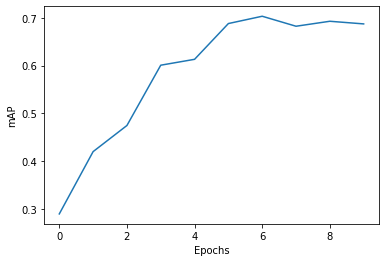

In [14]:
%%time
BEST_WEIGHTS = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/dlassignment1/q3/freeze_model/csv_retinanet_best_model.pt"

parser = {"csv_classes":CLASS_LIST, "csv_val":VAL_CSV, "csv_train":TRAIN_CSV, "epochs":10 }

dataset_train = CSVDataset(train_file=parser["csv_train"], class_list=parser["csv_classes"],
                                   transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))
dataset_val = CSVDataset(train_file=parser["csv_val"], class_list=parser["csv_classes"],
                                     transform=transforms.Compose([Normalizer(), Resizer()]))

sampler = AspectRatioBasedSampler(dataset_train, batch_size=2, drop_last=False)
dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler)

sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)

retinanet = model.resnet50(num_classes=dataset_train.num_classes(),)

# for param in retinanet.parameters():
#     param.requires_grad = False
# for param in retinanet.classificationModel.output.parameters():
#     param.requires_grad = True
# for param in retinanet.regressionModel.output.parameters():
#     param.requires_grad = True

use_gpu = True

if use_gpu:
    retinanet = retinanet.cuda()

PATH_TO_DATASET = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/assignment-data"
PATH_TO_WEIGHTS = PATH_TO_DATASET + "/pretrained_weights_cleaned.pt"

retinanet.load_state_dict(torch.load(PATH_TO_WEIGHTS))
# retinanet = torch.load(BEST_WEIGHTS)

retinanet = torch.nn.DataParallel(retinanet).cuda()

retinanet.training = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, retinanet.parameters()), lr=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

loss_hist = collections.deque(maxlen=500)

loss_all_epochs = []
map_all_epochs = []

def avg(mAP):
  avg_map = 0
  for key in mAP:
    avg_map += mAP[key][0]
  avg_map /= 8

  print("Avg mAP",avg_map)

  return avg_map


retinanet.train()
retinanet.module.freeze_bn()
file1 = open("logfreezefour.txt","w")
print('Num training images: {}'.format(len(dataset_train)))

best_loss = 100
best_map = 0
for epoch_num in range(parser["epochs"]):
    print("\nEpoch",epoch_num)
    retinanet.train()
    retinanet.module.freeze_bn()

    # if epoch_num == 10:
    #   for param in retinanet.parameters():
    #     param.requires_grad = True
    #   optimizer = optim.Adam(filter(lambda p: p.requires_grad, retinanet.parameters()), lr=1e-5)
    
    # if epoch_num == 10:
    #   for param in retinanet.parameters():
    #       param.requires_grad = False
    #   for param in retinanet.classificationModel.output.parameters():
    #       param.requires_grad = True
    #   for param in retinanet.regressionModel.output.parameters():
    #       param.requires_grad = True
    #   optimizer = optim.Adam(filter(lambda p: p.requires_grad, retinanet.parameters()), lr=1e-5)

    epoch_loss = []

    for iter_num, data in enumerate(dataloader_train):
        try:
            optimizer.zero_grad()

            classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot']])

            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()

            loss = classification_loss + regression_loss

            if bool(loss == 0):
                continue

            loss.backward()

            torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)

            optimizer.step()

            loss_hist.append(float(loss))

            epoch_loss.append(float(loss))

            # print(
            #     'Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
            #         epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))
            
            file1.write('Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f} \n'.format(
                    epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))
            
            del classification_loss
            del regression_loss
        except Exception as e:
            print(e)
            continue

    print('Evaluating dataset')

    mAP = csv_eval.evaluate(dataset_val, retinanet)
    avg_mAP = avg(mAP)
    map_all_epochs.append(avg_mAP)

    mean_loss = np.mean(epoch_loss)

    scheduler.step(mean_loss)

    loss_all_epochs.append(mean_loss)


    if(mean_loss < best_loss):
        torch.save(retinanet.module, 'freeze_model/fourth/{}_retinanet_{}.pt'.format("csv", "best_model_loss"))
        best_loss = mean_loss
    
    if(avg_mAP > best_map):
      torch.save(retinanet.module, 'freeze_model/fourth/{}_retinanet_{}.pt'.format("csv", "best_model_mAP"))
      best_map = avg_mAP
    
    torch.save(retinanet.module, 'freeze_model/fourth/{}_retinanet_{}.pt'.format("csv", epoch_num))
    print("Best loss:",best_loss,"Best mAP:",best_map)

retinanet.eval()
file1.close()
torch.save(retinanet, 'freeze_model/fourth/model_final.pt')

print("Loss curve")
x_axis = [x for x in range(parser["epochs"])]
plt.plot(x_axis,loss_all_epochs)
plt.xlabel("Epochs")
plt.ylabel("Running Loss")
plt.savefig("/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/dlassignment1/q3/freeze_model/fourth/losscurve.png")

plt.figure()
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.plot(x_axis,map_all_epochs)
plt.savefig("/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/dlassignment1/q3/freeze_model/fourth/mapcurve.png")

In [0]:
print(loss_all_epochs)

[0.28988073679353826, 0.25252093812870424, 0.21545790356383748, 0.18868819646217716, 0.16916730437269176]


Loss curve


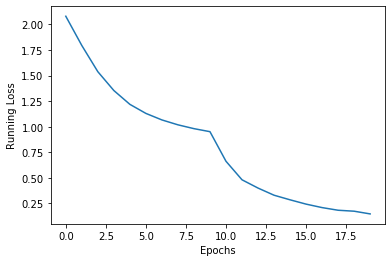

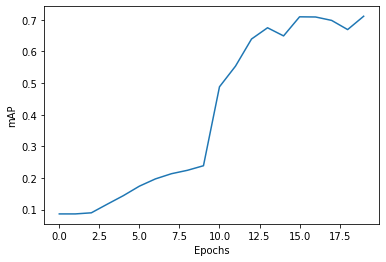

In [12]:
# print("Loss curve")
# x_axis = [x for x in range(parser["epochs"])]
# plt.plot(x_axis,loss_all_epochs)
# plt.xlabel("Epochs")
# plt.ylabel("Running Loss")
# plt.savefig("/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/dlassignment1/q3/freeze_model/third/losscurve.png")

# plt.figure()
# plt.xlabel("Epochs")
# plt.ylabel("mAP")
# plt.plot(x_axis,map_all_epochs)
# plt.savefig("/content/drive/My Drive/Deep_Learning_Assignments/Assignment1/Q3/dlassignment1/q3/freeze_model/third/mapcurve.png")
